***Sequence prediction with CNN and LR optimization***

BEST

dataset is NASDAQ open and volume -  40 year history


In [2]:
import csv
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass
from tensorflow.keras.models import Model
from tensorflow.python.keras.utils.vis_utils import plot_model
import pydot
from numpy import shape
import datetime
%load_ext tensorboard


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


**Global Variables**

In [3]:
MODEL_NUM=4
TRAINING_RATIO = .80
WINDOW_SIZE = 64
BATCH_SIZE = 1024
SHUFFLE_BUFFER = 1000
DATAFILE_CSV = 'd:/data/stocks/nasdaq1984.csv' # from https://finance.yahoo.com/quote/%5EIXIC/history/

**Describe the data**

In [4]:
def describe_datafile():
    with open(DATAFILE_CSV, 'r') as mydata:
        print("Header       :  {}".format(mydata.readline()))    
        print("First record :  {}".format(mydata.readline()))
        print("Second record:  {}".format(mydata.readline()))
    
describe_datafile()

Header       :  Date,Open,High,Low,Close,Adj Close,Volume

First record :  10/11/1984,244.199997,244.699997,244.199997,244.699997,244.699997,62860000

Second record:  10/12/1984,245.5,246.199997,245.5,246.199997,246.199997,58860000



**Parse the .csv data to numpy arrays and data dictionary**

In [5]:
def parse_data_from_file(filename):
    
    dates = []
    close = []
    volume= []

    with open(filename) as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
     
        for record in reader:                          # load file records into lists
            dates.append(record[0])
            close.append(float(record[4]))
            volume.append(float(record[6]))
        index=list(range(0,len(dates)))                 # create the index
        
        for datalist in [index, dates, close, volume]:   # turn them into numpy arrays
            datalist=np.array(datalist)
 
        # Log, Normalize and flip
        close=np.divide(close,15000)
        volume=np.divide(volume,1e10)
        #datalist = np.flip(datalist))  

        return index, dates, close, volume

index, dates, close, volume = parse_data_from_file(DATAFILE_CSV)

dataarrays= [ index ,  dates ,  close ,  volume]
datanames=['index', 'dates', 'close', 'volume']
datadic={}    

for datum in enumerate(dataarrays):
    print('{:<6} {}'.format(datanames[datum[0]],np.shape(datum[1])))
    datadic[datanames[datum[0]]]=datum[1]

print('\ndatadic {}'.format(str(datadic.keys())))

index  (9611,)
dates  (9611,)
close  (9611,)
volume (9611,)

datadic dict_keys(['index', 'dates', 'close', 'volume'])


**Plot Processed Data**

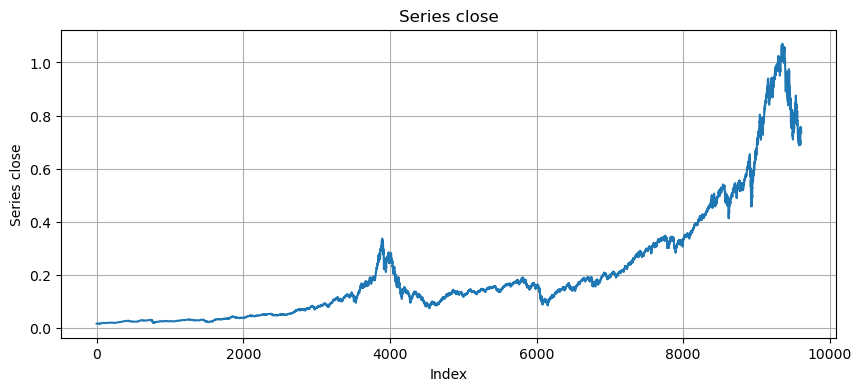

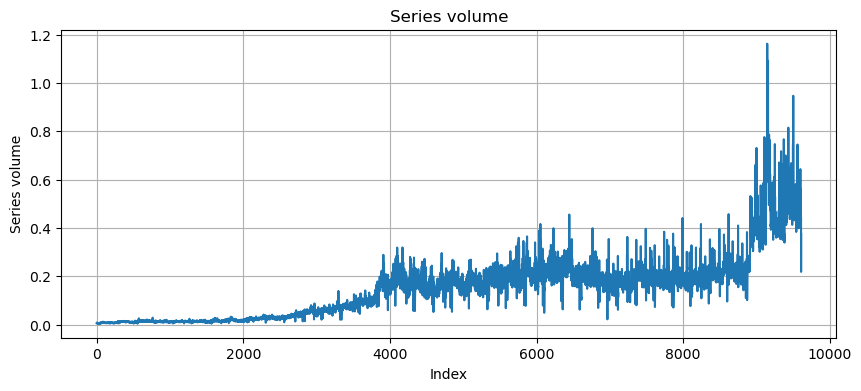

In [6]:
def plot_series(index, series, fignum=0,format="-", start=0, end=None):
            plt.figure(fignum, figsize=(10,4))
            plt.plot(index[start:end], series[start:end], format)
            plt.xlabel("Index")
            plt.ylabel("Series "+str(fignum))
            plt.grid(True)
            plt.title("Series "+str(fignum))

    
plot_series(index,close, 'close' )
plot_series(index,volume,'volume')

**Do Train and Validation splits**

In [8]:
def series_split(series, training_ratio=TRAINING_RATIO):
    first_validation=int(training_ratio*len(series))
    series_train = series[:first_validation]
    series_valid = series[first_validation:]
    
    return series_train, series_valid


# Split the datasets
datadic_train={}
datadic_val={}
print ('Default Training Ratio: {:.0f}%\n'.format(TRAINING_RATIO*100))

for datum in datadic:
    datadic_train[datum], datadic_val[datum] =series_split(datadic[datum])
    print('{:<8}  train shape: {}  validation shape: {}'.format(datum,shape(datadic_train[datum]), shape(datadic_val[datum])))#    datum, np.shape(datadic_train[datum]), np.shape(datadic_val[datum]) )

print ('\nOriginal series is {}'.format(np.shape(index)))
print('datadic_train: ',datadic_train.keys())
print('datadic_val  : ',datadic_val.keys())

Default Training Ratio: 80%

index     train shape: (7688,)  validation shape: (1923,)
dates     train shape: (7688,)  validation shape: (1923,)
close     train shape: (7688,)  validation shape: (1923,)
volume    train shape: (7688,)  validation shape: (1923,)

Original series is (9611,)
datadic_train:  dict_keys(['index', 'dates', 'close', 'volume'])
datadic_val  :  dict_keys(['index', 'dates', 'close', 'volume'])


**Create final data arrays**

In [9]:
data_all=np.stack((datadic['volume'],datadic['close']),axis=1)
data_train, data_val = series_split(data_all)

print('data_all  : ',np.shape(data_all))
print('data_train: ', np.shape(data_train))
print('data_val  : ', np.shape(data_val))


close_train, close_val = series_split(datadic['close'])
vol_train, vol_val = series_split(datadic['volume'])
index_train,index_val = series_split(index)

print('\nclose_train: ',np.shape(close_train))
print(  'vol_train  : ',np.shape(vol_train))


data_all  :  (9611, 2)
data_train:  (7688, 2)
data_val  :  (1923, 2)

close_train:  (7688,)
vol_train  :  (7688,)


***Create windowed dataset***

In [10]:
def windowed_dataset_multi(series1, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE, shuffle_buffer=SHUFFLE_BUFFER, shuffle=1, verbose=0):
    
    ds = tf.data.Dataset.from_tensor_slices(series1)
    if verbose==1:
        for elem in ds:
            print('created tensor: ')
            print('   ds elem:', elem)
            print('   ds elem[0]:',elem[0])
            print('   ds elem[1]:',elem[1])
            break
    
    #if shuffle==1: ds = ds.shuffle(shuffle_buffer)  
    
    ds = ds.window(window_size+1, shift=1, drop_remainder=True)  # +1 is the label
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.map(lambda w: (w[:-1], w[-1,1]))  # maps inputs and label
     
    if verbose==1:
        print('\nAfter batch map:')
        for elem in ds:
             print('   ds elem:', np.shape(elem))
             print('   ds elem[0][0] :',shape(elem[0]),elem[0][0])
             print('   ds elem[0][-1]:',shape(elem[0]),elem[0][-1])
             print('   ds elem[1]:',shape(elem[1]),elem[1])
             break
        
    ds = ds.batch(batch_size).prefetch(1)
    
    if verbose==1:
        print('\nAfter creating batches:')
        for elem in ds:
            print('   ds elem[0]:',shape(elem[0]))
            print('   ds elem[1]:',shape(elem[1]),elem[1][63],'\n')
            break
    
    return ds

# Apply the transformation to the training set

print('sending data_train: ',shape(data_train), type(data_train)) 
print('   data_train[0,0]',data_train[0,0])
print('   data_train[0,1]',data_train[0,1],'\n')

train_set  = windowed_dataset_multi(data_train, window_size=64, batch_size=BATCH_SIZE, shuffle_buffer=SHUFFLE_BUFFER, verbose=1,shuffle=1)
val_set  = windowed_dataset_multi(data_val, window_size=64, batch_size=BATCH_SIZE, shuffle_buffer=SHUFFLE_BUFFER, shuffle=0)


sending data_train:  (7688, 2) <class 'numpy.ndarray'>
   data_train[0,0] 0.006286
   data_train[0,1] 0.016313333133333333 

created tensor: 
   ds elem: tf.Tensor([0.006286   0.01631333], shape=(2,), dtype=float64)
   ds elem[0]: tf.Tensor(0.006286, shape=(), dtype=float64)
   ds elem[1]: tf.Tensor(0.016313333133333333, shape=(), dtype=float64)

After batch map:
   ds elem: (2,)
   ds elem[0][0] : (64, 2) tf.Tensor([0.006286   0.01631333], shape=(2,), dtype=float64)
   ds elem[0][-1]: (64, 2) tf.Tensor([0.007152   0.01681333], shape=(2,), dtype=float64)
   ds elem[1]: () tf.Tensor(0.017033333333333334, shape=(), dtype=float64)

After creating batches:
   ds elem[0]: (1024, 64, 2)
   ds elem[1]: (1024,) tf.Tensor(0.0187400004, shape=(), dtype=float64) 



C:\Users\Tom\anaconda3\envs\TensorflowGPU\lib\site-packages\numpy\core\fromnumeric.py:2007: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


In [11]:
for elem in train_set:
    print('last close in window: ',elem[0][-1,-1,1])  # [inputs][batch, window, volume]
    print('label for next close: ',elem[1][-1])       # [labels][batch, window, close ]
    print('percent change: {:+3.2}%'.format(float(elem[0][-1,-1,1])/float(elem[1][-1])*100-100))
    print('\n')
    break
    

last close in window:  tf.Tensor(0.026613334133333333, shape=(), dtype=float64)
label for next close:  tf.Tensor(0.026753332533333334, shape=(), dtype=float64)
percent change: -0.52%




**Define the model**

In [12]:
def create_model():

        # inputs
        input_layer=tf.keras.Input(shape=(WINDOW_SIZE,2))  #both
        x=input_layer[:,:,1]       # batch, window, close
        y=input_layer[:,-32:,0]       # batch, window, volume
        s1=input_layer[:,-1,1]  # batch, last value, close

        # close lstms
        x=tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None])(x)
        x=tf.keras.layers.LSTM(128, return_sequences=True, activation='tanh')(x)
        x=tf.keras.layers.LSTM(128, return_sequences=True, activation='tanh')(x)
        x=tf.keras.layers.LSTM(128)(x)
        
        # volume convolutions
        y=tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None])(y)
        y=tf.keras.layers.Conv1D(filters=16, kernel_size=7, strides=1, padding='same', activation='relu')(y)
        y=tf.keras.layers.Dense(1)(y)
        y=tf.keras.layers.Flatten()(y)

        # skip route
        s1=tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None])(s1)        
        
        # master DNN
        z=tf.keras.layers.Concatenate(axis=1,)([x,y,s1])     
        z=tf.keras.layers.Dense(128)(z)
        z=tf.keras.layers.Dense(64)(z)
        z=tf.keras.layers.Dense(32)(z)
        z=tf.keras.layers.Dense(16)(z)
        z=tf.keras.layers.Concatenate(axis=1,)([z,s1])
        
        
        # output
        output_layer=tf.keras.layers.Dense(1)(z)       
        model = Model(inputs=input_layer, outputs=output_layer)
    
        return model

In [13]:
tuning_model=create_model()
tuning_model.summary()
print('predictions returned: ',shape(tuning_model.predict(train_set)))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 2)]      0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 64)           0           input_1[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_1 (Sli (None, 32)           0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 64, 1)        0           tf.__operators__.getitem[0][0]   
______________________________________________________________________________________________

**Try a range of learning rates** 
- tf.keras.optimizers.Adam
- tf.keras.optimizers.SGD with a momentum of 0.9

In [15]:
def try_learning_rates(model, dataset):
    
    
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))

    #optimizer=tf.keras.optimizers.Adam(learning_rate=5.e-5 )
    optimizer=tf.keras.optimizers.SGD (learning_rate=5.e-5, momentum=.9) 
    
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer, 
                  metrics=["mae"]) 
    
    history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])
    
    return history

# Train in a range of learning rates


tuning_model=create_model() 
lr_history = try_learning_rates(tuning_model,train_set)


Epoch 1/100
8/8 [==============================] - 5s 96ms/step - loss: 0.0144 - mae: 0.1414
Epoch 2/100
8/8 [==============================] - 1s 94ms/step - loss: 0.0119 - mae: 0.1248
Epoch 3/100
8/8 [==============================] - 1s 92ms/step - loss: 0.0087 - mae: 0.0996
Epoch 4/100
8/8 [==============================] - 1s 92ms/step - loss: 0.0063 - mae: 0.0859
Epoch 5/100
8/8 [==============================] - 1s 92ms/step - loss: 0.0048 - mae: 0.0786
Epoch 6/100
8/8 [==============================] - 1s 92ms/step - loss: 0.0042 - mae: 0.0755
Epoch 7/100
8/8 [==============================] - 1s 92ms/step - loss: 0.0040 - mae: 0.0752
Epoch 8/100
8/8 [==============================] - 1s 92ms/step - loss: 0.0041 - mae: 0.0761
Epoch 9/100
8/8 [==============================] - 1s 92ms/step - loss: 0.0043 - mae: 0.0771
Epoch 10/100
8/8 [==============================] - 1s 92ms/step - loss: 0.0043 - mae: 0.0775
Epoch 11/100
8/8 [==============================] - 1s 92ms/step - lo

8/8 [==============================] - 1s 93ms/step - loss: nan - mae: nan           
Epoch 88/100
8/8 [==============================] - 1s 92ms/step - loss: nan - mae: nan
Epoch 89/100
8/8 [==============================] - 1s 92ms/step - loss: nan - mae: nan
Epoch 90/100
8/8 [==============================] - 1s 92ms/step - loss: nan - mae: nan
Epoch 91/100
8/8 [==============================] - 1s 93ms/step - loss: nan - mae: nan
Epoch 92/100
8/8 [==============================] - 1s 92ms/step - loss: nan - mae: nan
Epoch 93/100
8/8 [==============================] - 1s 93ms/step - loss: nan - mae: nan
Epoch 94/100
8/8 [==============================] - 1s 92ms/step - loss: nan - mae: nan
Epoch 95/100
8/8 [==============================] - 1s 92ms/step - loss: nan - mae: nan
Epoch 96/100
8/8 [==============================] - 1s 94ms/step - loss: nan - mae: nan
Epoch 97/100
8/8 [==============================] - 1s 93ms/step - loss: nan - mae: nan
Epoch 98/100
8/8 [================

**Review results and set optimized learning rate**

dict_keys(['loss', 'mae', 'lr'])


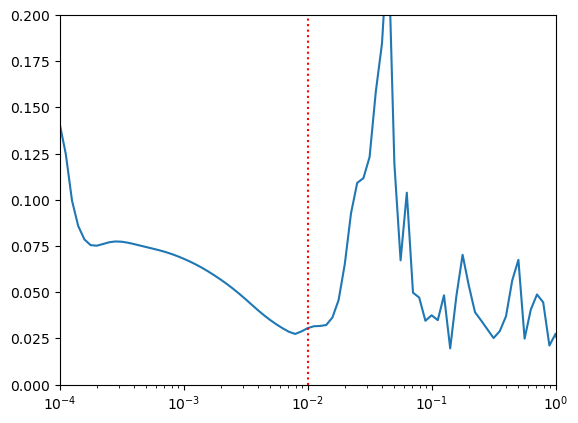

In [17]:
LEARNING_RATE=1e-2               ##  This sets learning rate for the model below  ##
print(lr_history.history.keys())
plt.semilogx(lr_history.history["lr"], lr_history.history["mae"])
plt.axis([1e-4,1, 0, .2])
plt.axvline(x = LEARNING_RATE, color = 'r' ,linestyle='dotted')
plt.show()

**Create the model**

In [18]:
model = create_model()
model.summary()
print('predictions returned: ',shape(tuning_model.predict(train_set)))

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64, 2)]      0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_6 (Sli (None, 64)           0           input_3[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_7 (Sli (None, 32)           0           input_3[0][0]                    
__________________________________________________________________________________________________
lambda_6 (Lambda)               (None, 64, 1)        0           tf.__operators__.getitem_6[0][0] 
____________________________________________________________________________________________

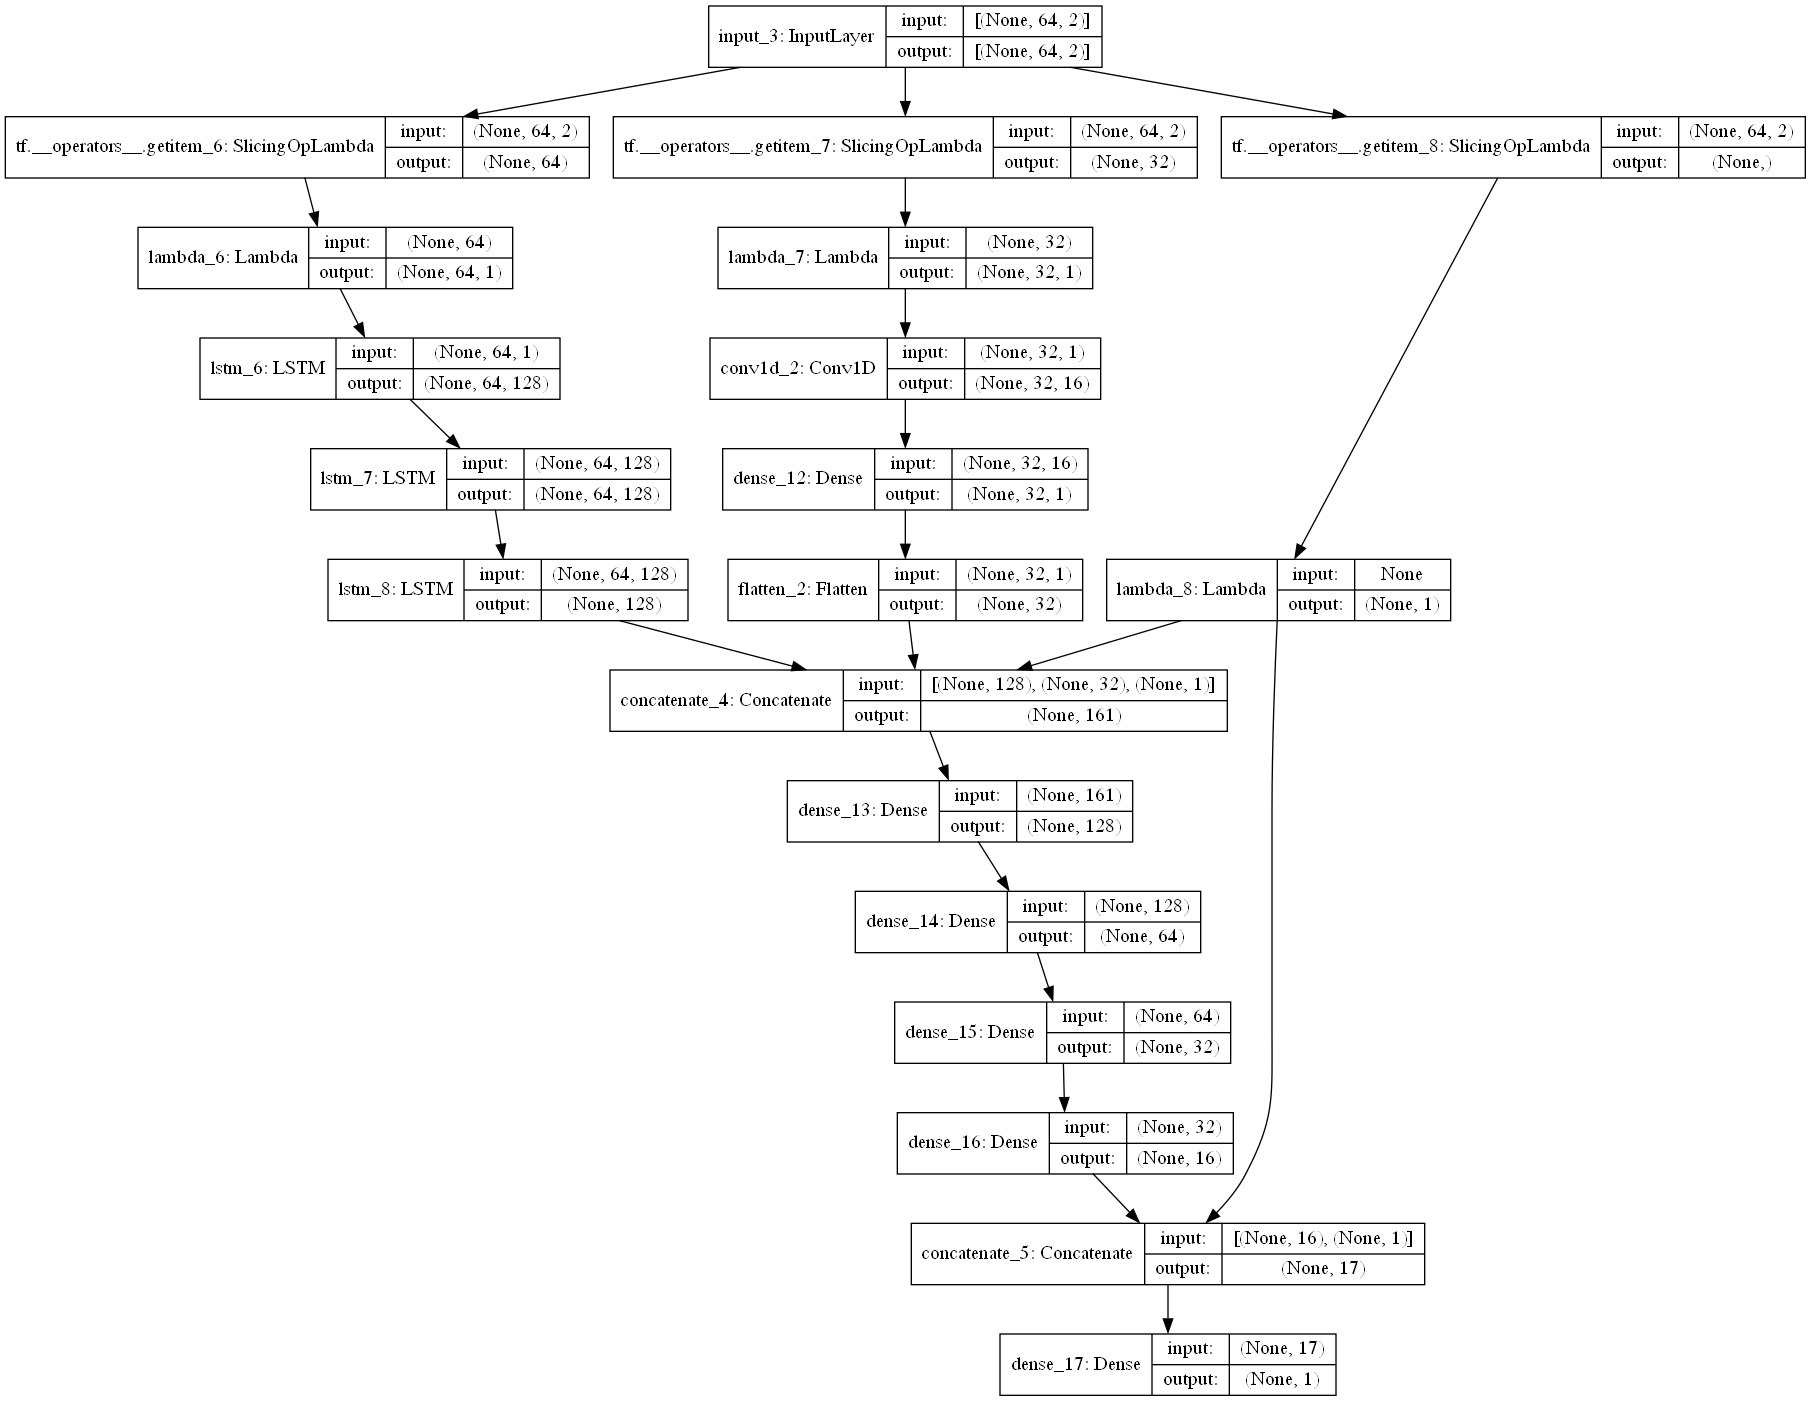

In [19]:
plot_model(model , to_file="nasdaq.png" , show_shapes= True , show_layer_names=True)

**Optimize, compile and train**

In [20]:
#callbacks
tensorboard_callback = tf.keras.callbacks.TensorBoard('tensorboard')
stop_callback = tf.keras.callbacks.EarlyStopping(patience=20, monitor='val_mae', verbose=1, mode='min', restore_best_weights=True)
lr_callback=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=10, min_lr=1e-4),
callbacks=[lr_callback, stop_callback]
#optimize & compile
optimizer=tf.keras.optimizers.SGD (learning_rate=LEARNING_RATE, momentum=.9) 
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])  
#train
history =  model.fit(train_set, epochs=300, callbacks=callbacks, verbose=1, validation_data=val_set)

Epoch 1/300
8/8 [==============================] - 6s 257ms/step - loss: 0.0026 - mae: 0.0510 - val_loss: 0.0972 - val_mae: 0.3618
Epoch 2/300
8/8 [==============================] - 1s 128ms/step - loss: 0.0184 - mae: 0.1804 - val_loss: 0.0780 - val_mae: 0.3313
Epoch 3/300
8/8 [==============================] - 1s 123ms/step - loss: 0.0169 - mae: 0.1599 - val_loss: 0.0904 - val_mae: 0.3989
Epoch 4/300
8/8 [==============================] - 1s 125ms/step - loss: 0.0065 - mae: 0.0954 - val_loss: 0.0758 - val_mae: 0.3740
Epoch 5/300
8/8 [==============================] - 1s 121ms/step - loss: 0.0056 - mae: 0.0933 - val_loss: 0.0437 - val_mae: 0.2753
Epoch 6/300
8/8 [==============================] - 1s 123ms/step - loss: 0.0016 - mae: 0.0408 - val_loss: 0.0257 - val_mae: 0.1944
Epoch 7/300
8/8 [==============================] - 1s 126ms/step - loss: 0.0041 - mae: 0.0777 - val_loss: 0.0376 - val_mae: 0.2528
Epoch 8/300
8/8 [==============================] - 1s 122ms/step - loss: 0.0016 - m

Epoch 61/300
8/8 [==============================] - 1s 119ms/step - loss: 5.3016e-05 - mae: 0.0063 - val_loss: 4.2019e-04 - val_mae: 0.0216
Epoch 62/300
8/8 [==============================] - 1s 118ms/step - loss: 5.2553e-05 - mae: 0.0063 - val_loss: 4.1438e-04 - val_mae: 0.0215
Epoch 63/300
8/8 [==============================] - 1s 119ms/step - loss: 5.2113e-05 - mae: 0.0063 - val_loss: 4.0903e-04 - val_mae: 0.0213
Epoch 64/300
8/8 [==============================] - 1s 119ms/step - loss: 5.1691e-05 - mae: 0.0062 - val_loss: 4.0408e-04 - val_mae: 0.0211
Epoch 65/300
8/8 [==============================] - 1s 119ms/step - loss: 5.1286e-05 - mae: 0.0062 - val_loss: 3.9949e-04 - val_mae: 0.0210

Epoch 00065: ReduceLROnPlateau reducing learning rate to 0.0019999999552965165.
Epoch 66/300
8/8 [==============================] - 1s 120ms/step - loss: 5.0412e-05 - mae: 0.0062 - val_loss: 3.7859e-04 - val_mae: 0.0202
Epoch 67/300
8/8 [==============================] - 1s 119ms/step - loss: 5.033

**Review training results**

In [6]:
print("History: {}".format(history.history.keys()))

acc = history.history['mae']
val_acc = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']
mae = history.history['mae']
val_mae = history.history['val_mae']
epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, mae, 'r', label="Training MAE")
plt.plot(epochs, val_mae, 'b', label="Validation MAE")
plt.title('MAE')
plt.legend(loc=0)
plt.show()
print('Training  : ',model.evaluate(train_set))
print('Validation: ',model.evaluate(val_set))

NameError: name 'history' is not defined

**Evaluate the forecast**

**Run predictions**

In [7]:
# Compute the forecast for validation
forecast = model.predict(val_set).squeeze()

NameError: name 'model' is not defined

In [72]:
#%tensorboard --logdir=tensorboard

**Review Results**

As of              : 11/28/2022
Yesterday forecast : 11,164
Today's close      : 11,049
Percent error      : 1.04%
Tomorrow's forecast: 11,205


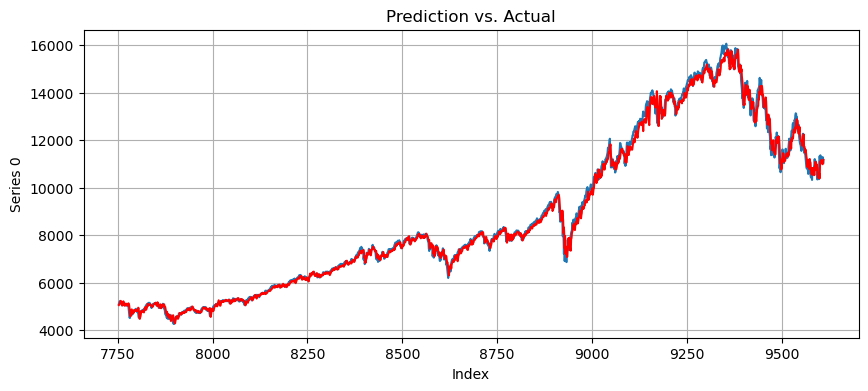

In [144]:
label_val=data_val[WINDOW_SIZE:,1]  # labels start at first value plus window
last=float(forecast[-1]) *15000
yesterday=float(forecast[-2]) *15000
true=float(   label_val[-1]) *15000
print ('As of              : {}'.format(dates[-1]))
print ('Yesterday forecast : {:,.0f}'.format(yesterday))
print ("Today's close      : {:,.0f}".format(true))
print ('Percent error      : {:.2f}%'.format((yesterday-true)*100/true))
print ("Tomorrow's forecast: {:,.0f}".format(last))




# Plot forecast vs. actual


plot_series(index_val[WINDOW_SIZE+1:], label_val[1:] *15000)
plot_series(index_val[WINDOW_SIZE+1:], forecast[:-1]*15000,format='r')
plt.title('Prediction vs. Actual')
plt.show()

In [122]:
def compute_metrics(true_series, forecast):
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()
    return mse, mae

mse, mae = compute_metrics(close_val[WINDOW_SIZE:], rnn_forecast.reshape(-1))

print("Forecast vs. labels: mse: {:.5f}, mae: {:.4f}".format(mse,mae))


Forecast vs. labels: mse: 0.00014, mae: 0.0084


**Make Prediction**

In [123]:
close=data_val[-1,1]*15000.

tomorrow_forecast=rnn_forecast[-1]*15000
gain_points=tomorrow_forecast-close
percent=gain_points/close*100.
print("as of                 {}:".format(dates[-1]))
print("today's close       : {:,.0f}".format(close))
print("tomorrow's forecast : {:,.0f}".format(float(tomorrow_forecast)))
print("predicted gain of: {:.2f} points or {:.2f}%\n".format(gain_points,percent))

as of                 11/28/2022:
today's close       : 11,049
tomorrow's forecast : 11,205
predicted gain of: 155.54 points or 1.41%



In [200]:
all_in=False
cash=10000.
shares=0
forecast_dates=datadic_val['dates'][WINDOW_SIZE:]
close_actual = close_val[WINDOW_SIZE:]  # actual results from next day to compare to prediction 
days_correct=0
days_incorrect=0

def norm_close(close):
    close=float(close)*15000.
    return close

for i in range(1,len(rnn_forecast)-1):    # can't use last because no true label
    buyhold=10000.*close_actual[i]/close_actual[0]
    if close_actual[i+1]>close_actual[i] and shares==0: 
        error='Should be invested'
        days_incorrect+=1
    elif close_actual[i+1]<close_actual[i] and cash==0:
        error='Should be cash'
        days_incorrect+=1
    else: 
        error='Correct'
        days_correct+=1
    print('date: {}   Close: {:,.0f}  Forecast: {:,.0f}  Cash:{:,.0f}  Shares:{:,.2f} Total:{:,.0f} BH:{:,.2f}  {}'.format(\
        val_dates[i],norm_close(close_actual[i]), norm_close(rnn_forecast[i]),cash,shares,\
        cash+shares*norm_close(close_actual[i]), buyhold,error ))
    
    if rnn_forecast[i]>close_actual[i-1] and all_in is False:
        all_in =True
        shares=cash/norm_close(close_actual[i-1])
        cash=0
        print ('buying {:.2f} shares at {:,.0f}'.format(shares,norm_close(close_actual[i])))
        
    if rnn_forecast[i]<close_actual[i-1] and all_in is True:
        print ('selling {:.2f} shares at {:,.0f}'.format(shares,norm_close(close_actual[i])))
        all_in = False
        cash=shares*norm_close(close_actual[i-1])
        shares=0
    
print('days correct: {}      days incorrect: {}'.format(days_correct, days_incorrect) )
    

date: 7/15/2015   Close: 5,099  Forecast: 5,070  Cash:10,000  Shares:0.00 Total:10,000 BH:9,988.34  Should be invested
date: 7/16/2015   Close: 5,163  Forecast: 5,091  Cash:10,000  Shares:0.00 Total:10,000 BH:10,114.18  Should be invested
date: 7/17/2015   Close: 5,210  Forecast: 5,131  Cash:10,000  Shares:0.00 Total:10,000 BH:10,206.17  Should be invested
date: 7/20/2015   Close: 5,219  Forecast: 5,202  Cash:10,000  Shares:0.00 Total:10,000 BH:10,223.26  Correct
date: 7/21/2015   Close: 5,208  Forecast: 5,230  Cash:10,000  Shares:0.00 Total:10,000 BH:10,202.22  Correct
buying 1.92 shares at 5,208
date: 7/22/2015   Close: 5,172  Forecast: 5,181  Cash:0  Shares:1.92 Total:9,910 BH:10,131.01  Should be cash
selling 1.92 shares at 5,172
date: 7/23/2015   Close: 5,146  Forecast: 5,164  Cash:9,979  Shares:0.00 Total:9,979 BH:10,081.33  Correct
date: 7/24/2015   Close: 5,089  Forecast: 5,085  Cash:9,979  Shares:0.00 Total:9,979 BH:9,968.15  Correct
date: 7/27/2015   Close: 5,040  Forecast: 5

date: 4/14/2022   Close: 13,351  Forecast: 13,658  Cash:0  Shares:1.12 Total:14,994 BH:26,153.51  Should be cash
date: 4/18/2022   Close: 13,332  Forecast: 13,516  Cash:0  Shares:1.12 Total:14,973 BH:26,116.84  Correct
date: 4/19/2022   Close: 13,620  Forecast: 13,605  Cash:0  Shares:1.12 Total:15,295 BH:26,679.63  Should be cash
date: 4/20/2022   Close: 13,453  Forecast: 13,795  Cash:0  Shares:1.12 Total:15,108 BH:26,353.30  Should be cash
date: 4/21/2022   Close: 13,175  Forecast: 13,621  Cash:0  Shares:1.12 Total:14,796 BH:25,807.90  Should be cash
date: 4/22/2022   Close: 12,839  Forecast: 13,192  Cash:0  Shares:1.12 Total:14,419 BH:25,150.96  Correct
date: 4/25/2022   Close: 13,005  Forecast: 12,872  Cash:0  Shares:1.12 Total:14,605 BH:25,475.28  Should be cash
date: 4/26/2022   Close: 12,491  Forecast: 12,979  Cash:0  Shares:1.12 Total:14,028 BH:24,468.19  Should be cash
selling 1.12 shares at 12,491
date: 4/27/2022   Close: 12,489  Forecast: 12,651  Cash:14,605  Shares:0.00 Tota

**Save Model**

In [197]:
# Save your model into a HDF5 file
filename=input("Enter filename: ")+".h5"
print('Saving file: ',filename)
model.save(filename)

Enter filename: 99.2percent
Saving file:  99.2percent.h5
